In [7]:
# packages to import: xmitgcm, matplotlib, numpy, os, sys, ecco_v4_py, pandas, warnings, pandas, cmocean, xarray
import xmitgcm 
import numpy as np
from os.path import expanduser,join,isdir
import sys
import xarray as xr
user_home_dir = expanduser('~')
ecco_v4_py_dir = join(user_home_dir,'ECCOv4-py')
if isdir(ecco_v4_py_dir):
    sys.path.insert(0,ecco_v4_py_dir)
import ecco_v4_py as ecco
import matplotlib.cm as cm
from ecco_v4_py import get_llc_grid as get_llc_grid
from ecco_v4_py import plot_proj_to_latlon_grid
import ecco_v4_py.ecco_access as ea
from matplotlib import pyplot as plt
import os
import warnings
import cmocean
warnings.filterwarnings("ignore")
import pandas as pd

# SIMPLE PLOTS

In [2]:
data_dir = "/efs_ecco/hvanderz/r5/WORKINGDIR/ECCOV4/release5/run/" # directory where your files for the run without tides are
data_dir_tides = "/efs_ecco/hvanderz/r5/WORKINGDIR/ECCOV4/release5_ToTs/run/" # directory where your files for the run with tides are

In [3]:
# opening data: remember that you need to consider the correct prefix, so anything that is before the first dot
ds_eta = xmitgcm.open_mdsdataset(data_dir+"diags/ETAN_mon_mean", grid_dir=data_dir, iters='all', prefix="ETAN_mon_mean", geometry="llc")

In [4]:
ds_eta_tides = xmitgcm.open_mdsdataset(data_dir_tides+"diags/", grid_dir=data_dir_tides, iters='all', prefix="ETAN_snapD", geometry="llc")

In [5]:
# opening of more than one variable with the same time step
variables = ["UVEL", "VVEL", "THETA", "SALT"]

datasets = []
for var in variables:
    path = os.path.join(data_dir+"diags/", f"{var}_mon_mean/")
    prefix = f"{var}_mon_mean"
    ds = xmitgcm.open_mdsdataset(path, grid_dir=data_dir, iters='all', prefix=prefix, geometry="llc")
    datasets.append(ds)

ds = xr.merge(datasets)

datasets_tides = []
for var in variables:
    path = os.path.join(data_dir_tides+"diags/", f"{var}_mon_mean/")
    prefix = f"{var}_mon_mean"
    ds_tides = xmitgcm.open_mdsdataset(path, grid_dir=data_dir_tides, iters='all', prefix=prefix, geometry="llc")
    datasets_tides.append(ds_tides)

ds_tides = xr.merge(datasets_tides)

In [6]:
# define some useful colormaps where NaNs are black
colMap = cm.RdBu_r
colMap.set_bad(color='black')

jet_colMap_k = cm.jet
jet_colMap_k.set_bad(color='black')

jet_colMap_w = cm.jet
jet_colMap_w.set_bad(color='white')

In [7]:
# to use ecco_v4_py routines you need to rename face to tile
ds = ds.rename({"face": "tile"})
ds_tides = ds_tides.rename({"face": "tile"})
ds_eta = ds_eta.rename({"face": "tile"})
ds_eta_tides = ds_eta_tides.rename({"face": "tile"})

In [8]:
# since in ECCO models tiles are roteted you need to use this to create fields of zonal and meridional velocity that consider the two directions correctly
xfld_tides = ds_tides.UVEL.isel(time=0).compute()
yfld_tides = ds_tides.VVEL.isel(time=0).compute()

# Compute the zonal and meridional vector components of velocity
oceU_tides, oceV_tides  = ecco.vector_calc.UEVNfromUXVY(xfld_tides, yfld_tides, ds_tides)

In [9]:
xfld = ds.UVEL.isel(time=0).compute()
yfld = ds.VVEL.isel(time=0).compute()

oceU, oceV  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ds)

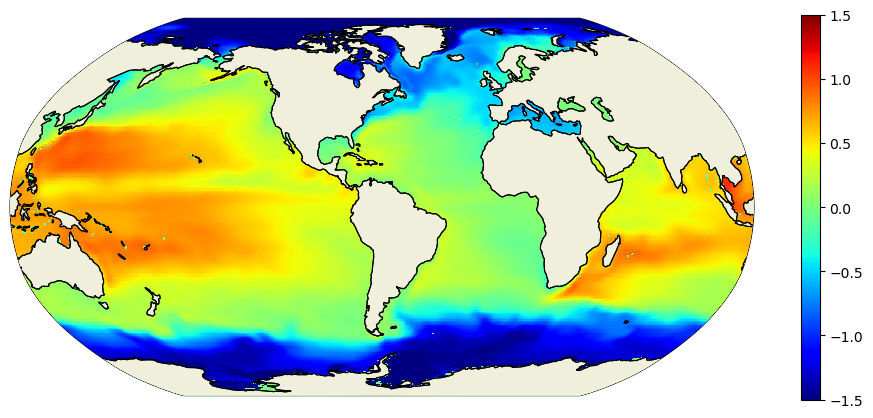

In [10]:
# plot on the world projection
plt.figure(figsize=[12,5]);
X = plot_proj_to_latlon_grid(ds.XC, ds.YC, ds_eta.ETAN.isel(time=0), 
                                  cmap=jet_colMap_w,
                                  show_colorbar=True, user_lon_0=-66, 
                                  cmin=-1.5,
                                  cmax=1.5)

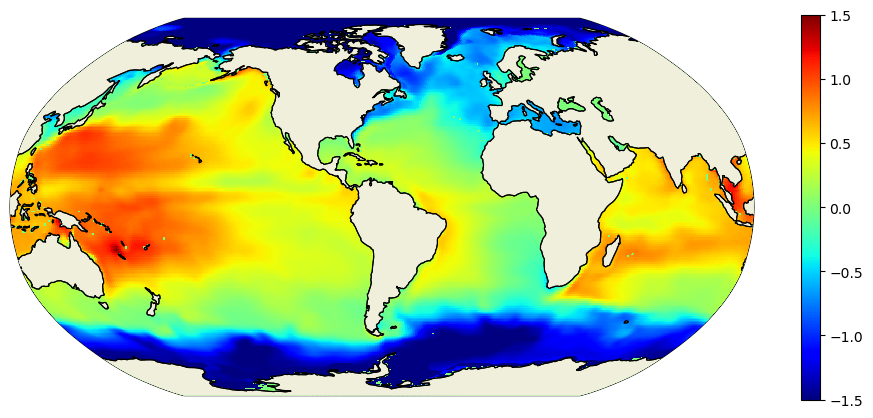

In [11]:
plt.figure(figsize=[12,5]);
X = plot_proj_to_latlon_grid(ds_tides.XC, ds_tides.YC, ds_eta_tides.ETAN.isel(time=200), 
                                  cmap=jet_colMap_w,
                                  show_colorbar=True, user_lon_0=-66, 
                                  cmin=-1.5,
                                  cmax=1.5)

In [12]:
# resample on the lat-lon normal grid
new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
ds_lat_lon =\
        ecco.resample_to_latlon(ds.XC, \
                                ds.YC, \
                                ds_eta.where(ds.maskC[0]).ETAN.isel(time=0),\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.nan, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000) 

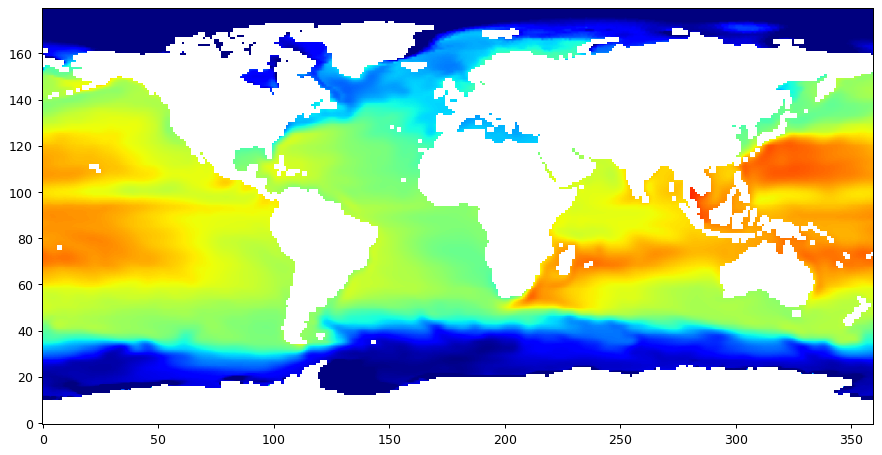

In [23]:
plt.figure(figsize=(12,6), dpi= 90)
plt.imshow(ds_lat_lon,origin='lower', cmap='jet', vmin = -1.5, vmax=1.5)

(<Figure size 900x789 with 17 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]]))

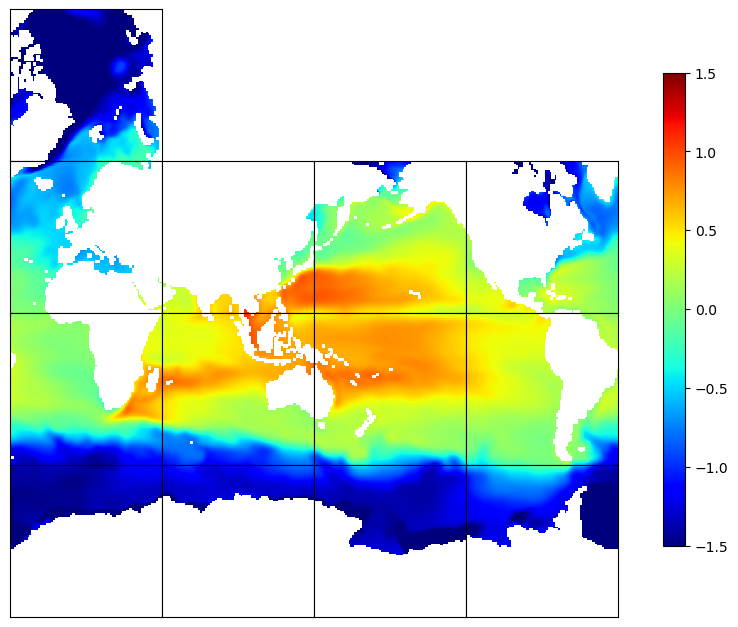

In [14]:
# plot of the different tiles divided
ecco.plot_tiles(ds_eta.ETAN.isel(time=0).where(ds.maskC[0]), layout='latlon', #mask
                rotate_to_latlon=True, 
                show_tile_labels=False, 
                show_colorbar=True, 
                cmap='jet',
                cmin=-1.5,cmax=1.5)

# PLOT OF TIMESERIES

In [2]:
data_dir_eta = "/efs_ecco/hvanderz/export_notide" # directory where output of ETAN for the NO tide run are
data_dir_tides_eta = "/efs_ecco/hvanderz/export_tides" # directory where output of ETAN for the tide run are
data_dir_var = "/efs_ecco/hvanderz/export2_notide" # directory where output of variables other than ETAN for the NO tide run are
data_dir_tides_var = "/efs_ecco/hvanderz/export2_tides" # directory where output of variables other than ETAN for the tide run are
grid_dir = "/efs_ecco/hvanderz/r5/WORKINGDIR/ECCOV4/release5/run/" # directory where grid is

In [3]:
ds_eta = xmitgcm.open_mdsdataset(data_dir_eta, grid_dir=grid_dir, iters='all', prefix="ETAN", geometry="llc")
ds_eta_tides = xmitgcm.open_mdsdataset(data_dir_tides_eta, grid_dir=grid_dir, iters='all', prefix="ETAN", geometry="llc")

In [4]:
variables = ["UVELMASS", "VVELMASS", "THETA", "SALT"]

datasets = []
for var in variables:
    path = os.path.join(data_dir_var, f"{var}_mon_mean/")
    prefix = f"{var}_mon_mean"
    ds = xmitgcm.open_mdsdataset(path, grid_dir=grid_dir, iters='all', prefix=prefix, geometry="llc")
    datasets.append(ds)

ds_var = xr.merge(datasets)

datasets_tides = []
for var in variables:
    path = os.path.join(data_dir_tides_var, f"{var}_mon_mean/")
    prefix = f"{var}_mon_mean"
    ds_tides = xmitgcm.open_mdsdataset(path, grid_dir=grid_dir, iters='all', prefix=prefix, geometry="llc")
    datasets_tides.append(ds_tides)

ds_tides_var = xr.merge(datasets_tides)

In [8]:
n_files = len(ds_eta_tides.time)             
start_time = '1992-01-01'    
freq = 'h'                   
time_eta = pd.date_range(start=start_time, periods=n_files, freq=freq)

In [9]:
n_files = len(ds_var.time)              
start_time = '1992-01-01'    
freq = 'm'                   
time_var = pd.date_range(start=start_time, periods=n_files, freq=freq)

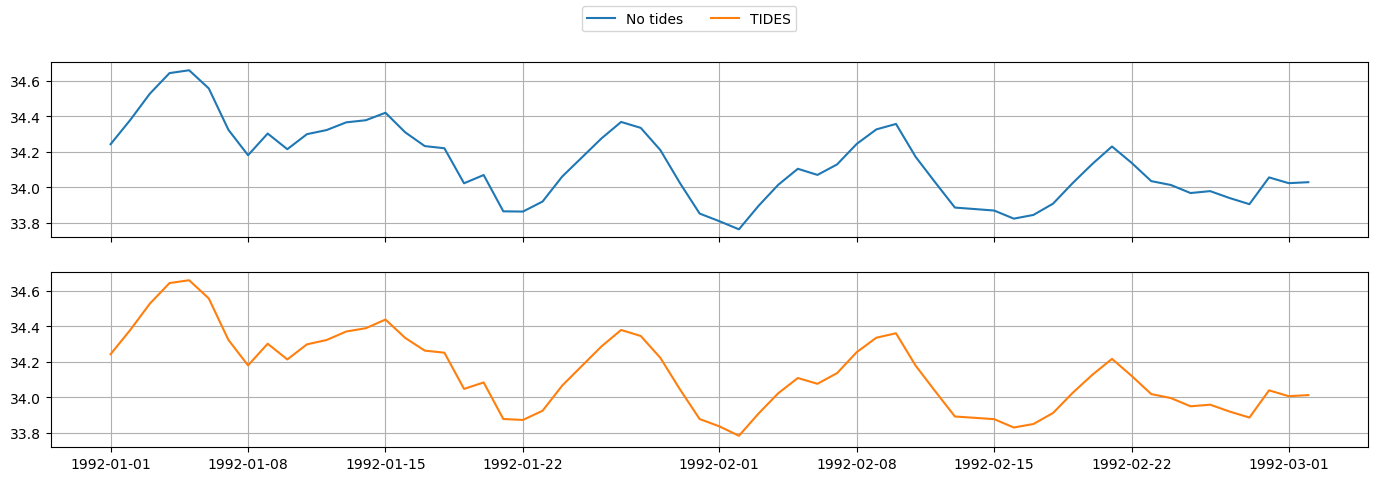

In [10]:
fig, (ax0, ax1) = plt.subplots(figsize=(17, 5), nrows=2, sharey=True, sharex=True)
ax0.plot(time_var, ds_var.SALT.isel(face=8, i=0, j=0, k=0).values, label="No tides", color="C0")
ax1.plot(time_var, ds_tides_var.SALT.isel(face=8, i=0, j=0, k=0).values, label="TIDES", color="C1")
fig.legend(ncol=2, loc="upper center")
ax0.grid()
ax1.grid()

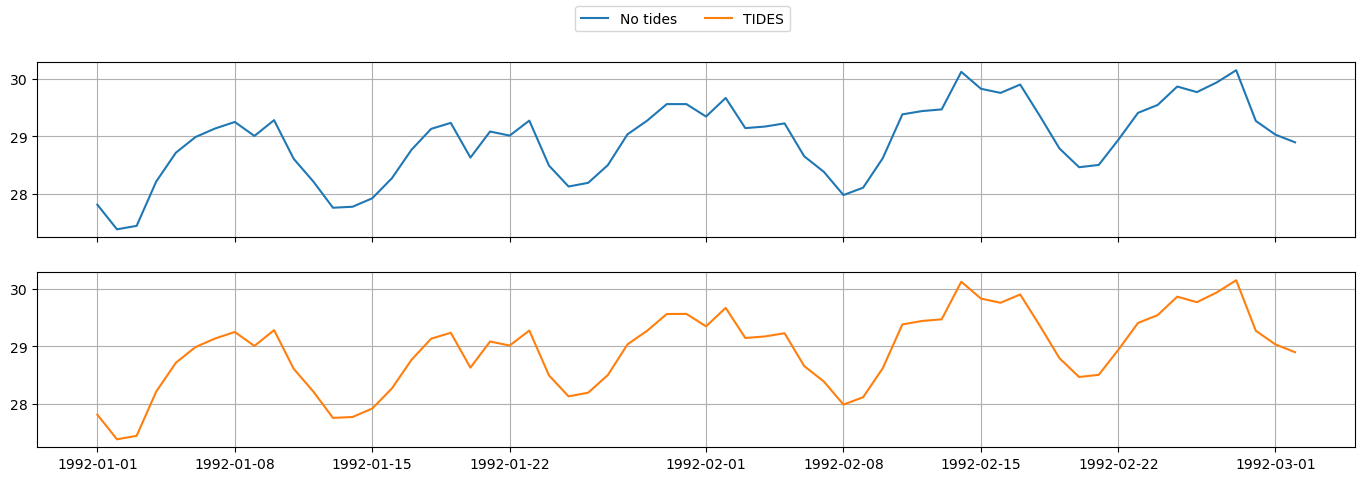

In [15]:
fig, (ax0, ax1) = plt.subplots(figsize=(17, 5), nrows=2, sharey=True, sharex=True)
ax0.plot(time_var, ds_var.THETA.isel(face=8, i=0, j=0, k=0).values, label="No tides", color="C0")
ax1.plot(time_var, ds_tides_var.THETA.isel(face=8, i=0, j=0, k=0).values, label="TIDES", color="C1")
fig.legend(ncol=2, loc="upper center")
ax0.grid()
ax1.grid()

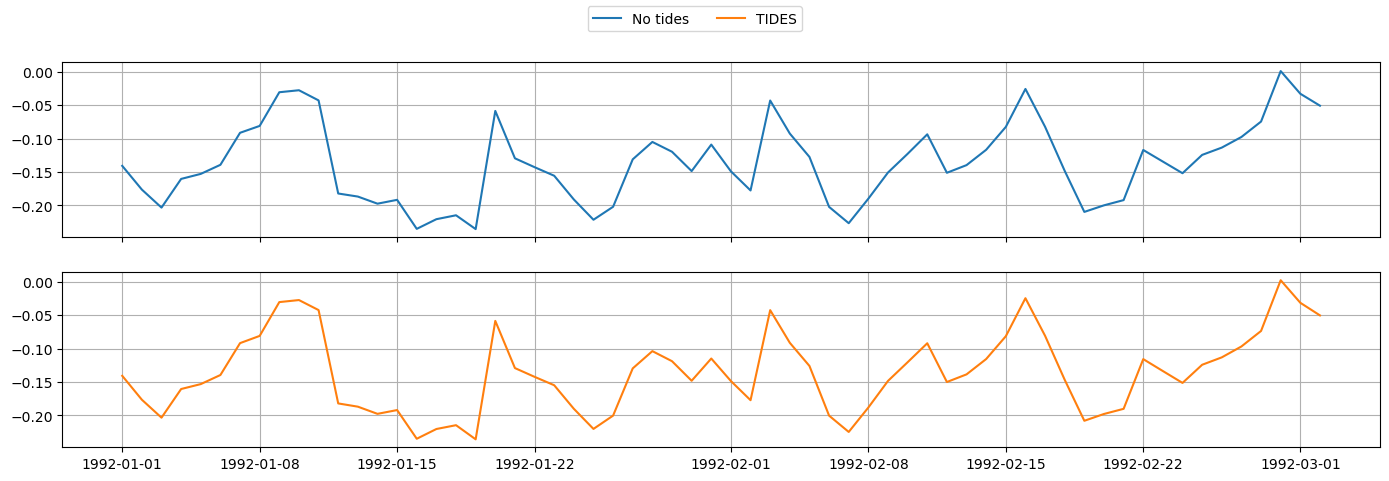

In [14]:
fig, (ax0, ax1) = plt.subplots(figsize=(17, 5), nrows=2, sharey=True, sharex=True)
ax0.plot(time_var, ds_var.VVELMASS.isel(face=8, i=0, j_g=0, k=0).values, label="No tides", color="C0")
ax1.plot(time_var, ds_tides_var.VVELMASS.isel(face=8, i=0, j_g=0, k=0).values, label="TIDES", color="C1")
fig.legend(ncol=2, loc="upper center")
ax0.grid()
ax1.grid()

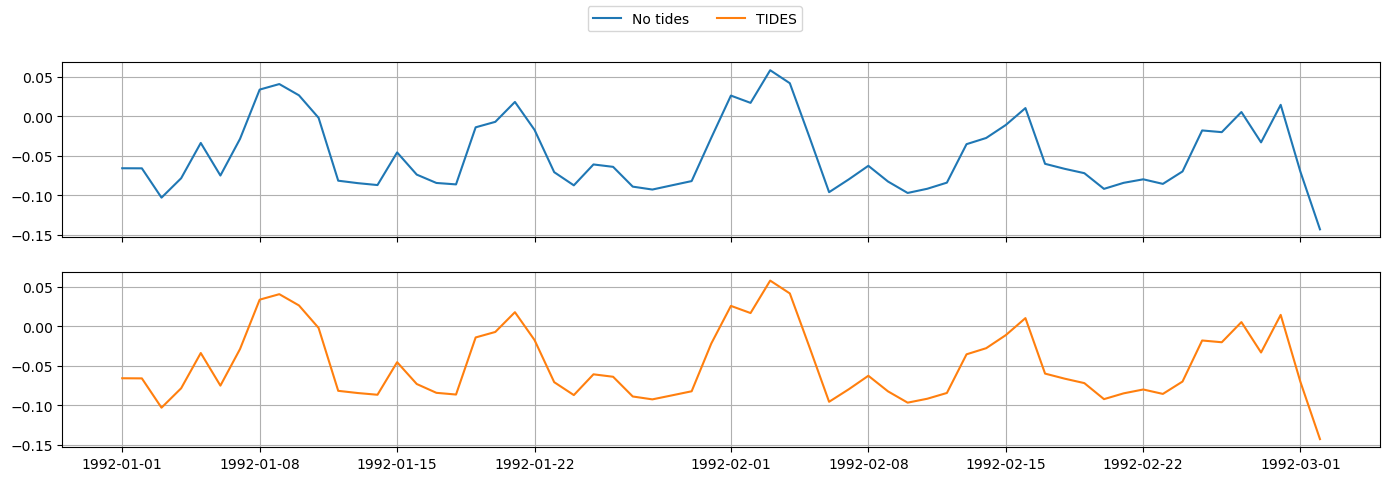

In [13]:
fig, (ax0, ax1) = plt.subplots(figsize=(17, 5), nrows=2, sharey=True, sharex=True)
ax0.plot(time_var, ds_var.UVELMASS.isel(face=8, i_g=0, j=0, k=0).values, label="No tides", color="C0")
ax1.plot(time_var, ds_tides_var.UVELMASS.isel(face=8, i_g=0, j=0, k=0).values, label="TIDES", color="C1")
fig.legend(ncol=2, loc="upper center")
ax0.grid()
ax1.grid()

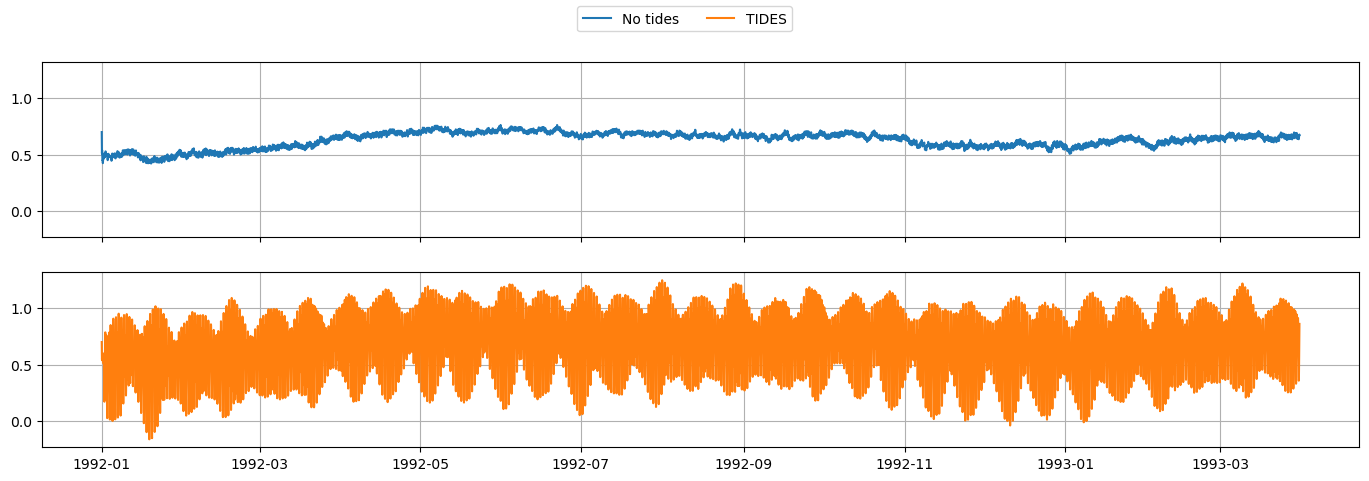

In [12]:
fig, (ax0, ax1) = plt.subplots(figsize=(17, 5), nrows=2, sharey=True, sharex=True)
ax0.plot(time_eta, ds_eta.ETAN.isel(face=8, i=0, j=0).values, label="No tides", color="C0")
ax1.plot(time_eta, ds_eta_tides.ETAN.isel(face=8, i=0, j=0).values, label="TIDES", color="C1")
fig.legend(ncol=2, loc="upper center")
ax0.grid()
ax1.grid()